<a href="https://colab.research.google.com/github/ripisan/wang.r.elliott-USGS/blob/implementation/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise SEP Developer Test

This test is designed to assess your ability to design and develop a project from a limited set of goals, provided below. We will evaluate your project based on its fulfillment of the outlined objectives, code efficiency, readability, and adherence to best practices. Additionally, we will evaluate the structure and content of your GitHub repository according to standard practices.

1. Please perform all coding within the Google Colab environment: http://colab.research.google.com
    * Please store your project in a GitHub repository, so we can fork and run it in Colab.
        * Additionally, please create a standard GitHub repository with the expected files and directory structure.    
    * Please note that Colab doesn't automatically include additional files. To avoid potential issues, we recommend only including files that the evaluators already have access to.    
    * The evaluators will use the files SEP01.mseed, SEP02.mseed, and SEP03.mseed, which can be found in this GitHub project.
2. Import the mseed files
3. Create a database with proper normal form and constraints
4. Import the data into the newly created database
5. Create a visualization for the data. The visualization can be static but must include:    
    * A title
    * Text section displaying metadata about the miniseed data
    * Helicorder-style charts of the miniseed data (These may be built from the database data or the mseed files)
    * A map with icons indicating station locations based on the miniseed data (station lat and lon can be found on iris' API)
    * Add to the map additional stations found on IRIS' data API. Stations of interest include HOA and SUG
        * Data API information can be found at http://service.iris.edu/fdsnws/station/1/



In [1]:
################
# Dependencies #
################

try:
  import obspy
except ModuleNotFoundError:
  !pip -qq install obspy
  import obspy

import datetime
import folium
import matplotlib.pyplot as plt
import numpy as np
import os
import sqlite3

from obspy.clients.fdsn import Client

# Remove sample_data folder
!rm -rf sample_data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [2]:
######################
# Import mseed files #
######################

if not os.path.exists('/content/SEP01.mseed'):
  !wget https://raw.githubusercontent.com/ripisan/wang.r.elliott-USGS/main/data/SEP01.mseed -O /content/SEP01.mseed
if not os.path.exists('/content/SEP02.mseed'):
  !wget https://raw.githubusercontent.com/ripisan/wang.r.elliott-USGS/main/data/SEP02.mseed -O /content/SEP02.mseed
if not os.path.exists('/content/SEP03.mseed'):
  !wget https://raw.githubusercontent.com/ripisan/wang.r.elliott-USGS/main/data/SEP03.mseed -O /content/SEP03.mseed

--2025-01-02 01:39:34--  https://raw.githubusercontent.com/ripisan/wang.r.elliott-USGS/main/data/SEP01.mseed
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9957376 (9.5M) [application/octet-stream]
Saving to: ‘/content/SEP01.mseed’

/content/SEP01.msee 100%[===================>]   9.50M  --.-KB/s    in 0.1s    

2025-01-02 01:39:35 (71.3 MB/s) - ‘/content/SEP01.mseed’ saved [9957376/9957376]

--2025-01-02 01:39:35--  https://raw.githubusercontent.com/ripisan/wang.r.elliott-USGS/main/data/SEP02.mseed
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

In [3]:
###################
# Create Database #
###################

# Connects to database, creates if it doesn't exist
conn = sqlite3.connect('db.sqlite')
cursor = conn.cursor()

# Create table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS seismic_data (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        network TEXT,
        station TEXT,
        location TEXT,
        channel TEXT,
        starttime TEXT,
        endtime TEXT,
        sampling_rate REAL,
        delta REAL,
        npts INTEGER,
        calib REAL,
        data BLOB
    )
''')

conn.commit()
conn.close()

In [4]:
###############
# Import Data #
###############
conn = sqlite3.connect('db.sqlite')
cursor = conn.cursor()

def insert_data(stream):
    for trace in stream:
      data_bytes = trace.data.tobytes()
      cursor.execute('''
        INSERT INTO seismic_data (network, station, location, channel, starttime, endtime, sampling_rate, delta, npts, calib, data)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''',
        (trace.stats.network,
         trace.stats.station,
         trace.stats.location,
         trace.stats.channel,
         str(trace.stats.starttime),
         str(trace.stats.endtime),
         trace.stats.sampling_rate,
         trace.stats.delta,
         trace.stats.npts,
         trace.stats.calib,
         data_bytes))

try:
    sep01 = obspy.read("/content/SEP01.mseed")
    insert_data(sep01)

    sep02 = obspy.read("/content/SEP02.mseed")
    insert_data(sep02)

    sep03 = obspy.read("/content/SEP03.mseed")
    insert_data(sep03)

    conn.commit()
    print("Data inserted successfully")

except FileNotFoundError:
    print("One or more .mseed files not found. Check if they are in the /content directory.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    conn.close()

Data inserted successfully


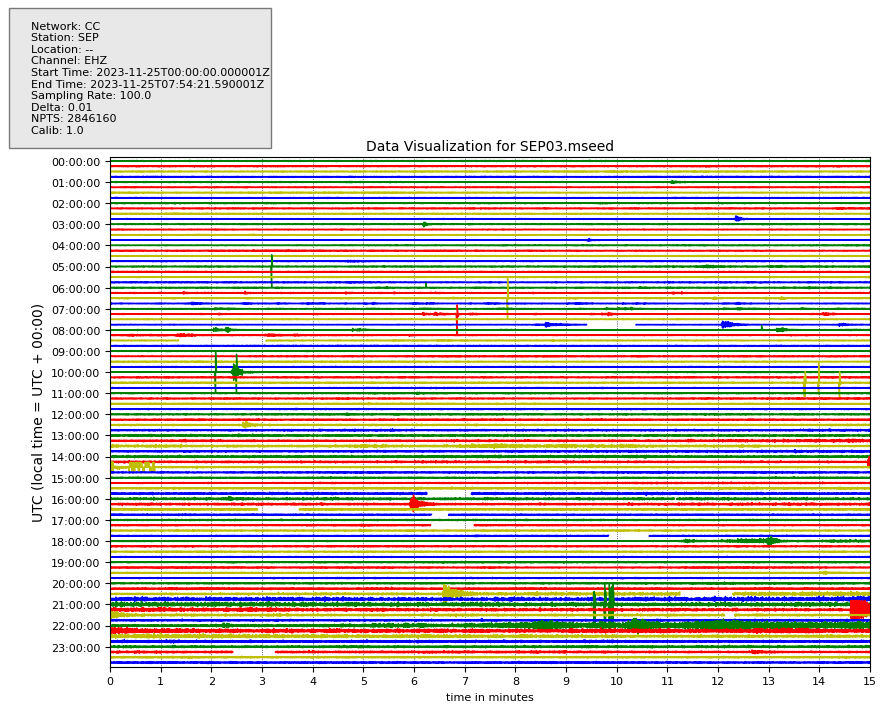

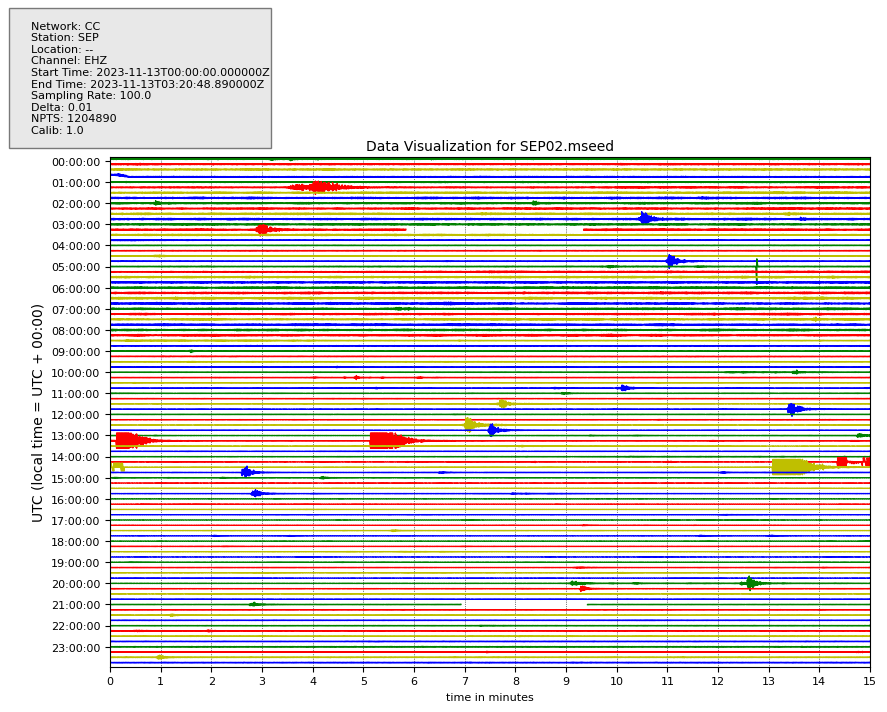

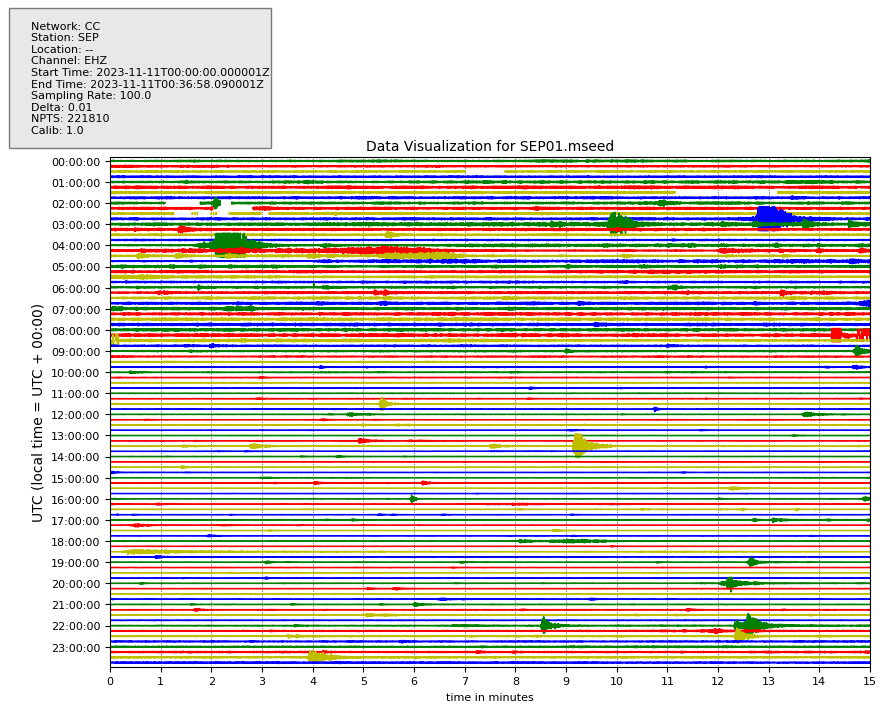

In [5]:
#########################
# Visualization of Data #
#########################

def plot_data(filePath):
    result = obspy.read(filePath)
    trace = result[0]

    metadata_text = f"""
      Network: {trace.stats.network}
      Station: {trace.stats.station}
      Location: {trace.stats.location}
      Channel: {trace.stats.channel}
      Start Time: {str(trace.stats.starttime)}
      End Time: {str(trace.stats.endtime)}
      Sampling Rate: {trace.stats.sampling_rate}
      Delta: {trace.stats.delta}
      NPTS: {trace.stats.npts}
      Calib: {trace.stats.calib}
    """
    fig = plt.figure(figsize=(10, 6))
    fig.text(0.02, 0.97, metadata_text, fontsize=8, bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 1})
    result.plot(type='dayplot', color=['g','r','y','b'], fig=fig, title=f"Data Visualization for {filePath}")
    plt.show()

try:
    for mseed in os.listdir('/content/'):
      if mseed.endswith('.mseed'):
        plot_data(mseed)

except Exception as e:
    print(f"An error occurred: {e}")


In [6]:
#####################
# Map with Stations #
#####################

def add_station_marker(latitude, longitude, station_name, color='blue'):
    folium.Marker(location=[latitude, longitude],
                  popup=station_name,
                  icon=folium.Icon(color=color)).add_to(m)

# Initialize map
m = folium.Map(location=[46.19978, -122.190857], zoom_start=12)

conn = sqlite3.connect('db.sqlite')
cursor = conn.cursor()

try:
    cursor.execute("SELECT station, network FROM seismic_data GROUP BY station")
    stations = cursor.fetchall()
    for station in stations:
        try:
            client = Client("IRIS")
            inventory = client.get_stations(network=station[1], station=station[0], level="response")

            for network in inventory:
              for station in network:
                  for channel in station:
                      latitude = channel.latitude
                      longitude = channel.longitude
                      station_name = f"{station.code} ({station.latitude}, {station.longitude})"
                      add_station_marker(latitude, longitude, station_name)

        except Exception as e:
            print(f"Error fetching data for station {station[0]}: {e}")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    conn.close()

# Add these two additional stations of interest
stations_of_interest = ["HOA", "SUG"]

for station_code in stations_of_interest:
    try:
        client = Client("IRIS")
        inventory = client.get_stations(station=station_code, level="response")

        for network in inventory:
          for station in network:
              for channel in station:
                  latitude = channel.latitude
                  longitude = channel.longitude
                  station_name = f"{station.code} ({station.latitude}, {station.longitude})"
                  add_station_marker(latitude, longitude, station_name, color='red')

    except Exception as e:
        print(f"Error fetching data for station {station_code}: {e}")

# Display Map
m